In [1]:
# Step 1: Mount Drive and preview the first few records from each file
from google.colab import drive
drive.mount('/content/drive')

import gzip, json, os

# UPDATE these paths if your files are in a different Drive folder
REVIEWS_PATH = '/content/drive/MyDrive/goodreads_reviews_comics_graphic.json.gz'
INTERACTIONS_PATH = '/content/drive/MyDrive/goodreads_interactions_comics_graphic.json.gz'
BOOKS_PATH = '/content/drive/MyDrive/goodreads_books_comics_graphic.json.gz'

# 1) quick existence check
for path in (REVIEWS_PATH, INTERACTIONS_PATH, BOOKS_PATH):
    print(path, '->', 'FOUND' if os.path.exists(path) else 'MISSING')

# helper to extract readable review text from a review JSON object
def extract_review_text(obj):
    if 'review_sentences' in obj:
        try:
            return " ".join([s[1] for s in obj['review_sentences'] if len(s) >= 2 and isinstance(s[1], str)])
        except Exception:
            return None
    for k in ('review_text', 'text', 'review'):
        if k in obj:
            return obj[k]
    return None

# 2) Preview first N records from a gzipped JSON-lines file
def preview_json_gz(path, n=3):
    if not os.path.exists(path):
        print(f">>> File not found: {path}")
        return
    print(f"\nPreviewing {os.path.basename(path)} (first {n} records):\n")
    with gzip.open(path, 'rt', encoding='utf-8', errors='replace') as f:
        for i, line in enumerate(f):
            if i >= n:
                break
            try:
                obj = json.loads(line)
            except Exception as e:
                print(f"  [error parsing line {i+1}]:", e)
                continue
            keys = list(obj.keys())
            print(f"--- Record {i+1} keys: {keys}")
            # try print a short snippet of review text (if any)
            text = extract_review_text(obj)
            if text:
                snippet = text[:400] + ("..." if len(text) > 400 else "")
                print("Text snippet:", snippet)
            else:
                print("No review text found in this record.")
            # print a few useful metadata fields if present
            for meta in ('review_id','book_id','user_id','rating','date_added','timestamp'):
                if meta in obj:
                    print(f"{meta}: {obj[meta]}")
            print()

# Run previews
preview_json_gz(REVIEWS_PATH, n=3)
preview_json_gz(INTERACTIONS_PATH, n=3)
preview_json_gz(BOOKS_PATH, n=2)


Mounted at /content/drive
/content/drive/MyDrive/goodreads_reviews_comics_graphic.json.gz -> FOUND
/content/drive/MyDrive/goodreads_interactions_comics_graphic.json.gz -> FOUND
/content/drive/MyDrive/goodreads_books_comics_graphic.json.gz -> FOUND

Previewing goodreads_reviews_comics_graphic.json.gz (first 3 records):

--- Record 1 keys: ['user_id', 'book_id', 'review_id', 'rating', 'review_text', 'date_added', 'date_updated', 'read_at', 'started_at', 'n_votes', 'n_comments']
Text snippet: Sherlock Holmes and the Vampires of London 
 Release Date: April 2014 
 Publisher: Darkhorse Comics 
 Story by: Sylvain Cordurie 
 Art by: Laci 
 Colors by: Axel Gonzabo 
 Cover by: Jean Sebastien Rossbach 
 ISDN: 9781616552664 
 MSRP: $17.99 Hardcover 
 "Sherlock Holmes died fighting Professor Moriarty in the Reichenbach Falls. 
 At least, that's what the press claims. 
 However, Holmes is alive ...
review_id: 66b2ba840f9bd36d6d27f46136fe4772
book_id: 18471619
user_id: dc3763cdb9b2cae805882878eebb6a

In [2]:
import gzip
import json
import pandas as pd

# Path to your reviews file in Drive
reviews_file = "/content/drive/MyDrive/goodreads_reviews_comics_graphic.json.gz"

# Load a subset for now (to avoid memory issues in Colab)
reviews = []
with gzip.open(reviews_file, 'rt', encoding='utf-8') as f:
    for i, line in enumerate(f):
        if i > 20000:  # limit for testing first
            break
        data = json.loads(line)
        reviews.append({
            "review_id": data.get("review_id"),
            "book_id": data.get("book_id"),
            "user_id": data.get("user_id"),
            "rating": data.get("rating"),
            "review_text": data.get("review_text")
        })

df = pd.DataFrame(reviews)

print("Shape of DataFrame:", df.shape)
df.head(5)


Shape of DataFrame: (20001, 5)


,review_id,book_id,user_id,rating,review_text
0,66b2ba840f9bd36d6d27f46136fe4772,18471619,dc3763cdb9b2cae805882878eebb6a32,3,Sherlock Holmes and the Vampires of London \n ...
1,72f1229aba5a88f9e72f0dcdc007dd22,6315584,bafc2d50014200cda7cb2b6acd60cd73,4,"I've never really liked Spider-Man. I am, howe..."
2,a75309355f8662caaa5e2c92ab693d3f,29847729,bafc2d50014200cda7cb2b6acd60cd73,4,"A very quick introduction, this is coming out ..."
3,c3cc5a3e1d6b6c9cf1c044f306c8e752,18454118,bafc2d50014200cda7cb2b6acd60cd73,5,I've been waiting so long for this. I first st...
4,cc444be37ab0a42bfb4dd818cb5edd10,2239435,bafc2d50014200cda7cb2b6acd60cd73,4,The only thing more entertaining than this boo...


In [3]:
# Drop missing reviews
df = df.dropna(subset=["review_text"])

# Define popularity label based on rating
df["popular"] = df["rating"].apply(lambda x: 1 if x >= 4 else 0)

print(df["popular"].value_counts())
df[["review_text", "rating", "popular"]].head(10)


popular
1    13018
0     6983
Name: count, dtype: int64


,review_text,rating,popular
0,Sherlock Holmes and the Vampires of London \n ...,3,0
1,"I've never really liked Spider-Man. I am, howe...",4,1
2,"A very quick introduction, this is coming out ...",4,1
3,I've been waiting so long for this. I first st...,5,1
4,The only thing more entertaining than this boo...,4,1
5,Zombies... I really don't like zombies. That s...,3,0
6,This wasn't my favourite Black Butler book. I ...,3,0
7,Somehow I'd missed this one when reading every...,5,1
8,More tears than laughter in this one. I'm both...,5,1
9,I checked this out of the library as their Val...,3,0


In [4]:
import re

# Simple text cleaning function
def clean_text(text):
    text = text.lower()                          # lowercase
    text = re.sub(r'\n', ' ', text)             # remove newlines
    text = re.sub(r'\s+', ' ', text)            # replace multiple spaces with one
    text = re.sub(r'[^\w\s]', '', text)         # remove punctuation
    return text.strip()

# Apply cleaning to the review text
df["clean_review"] = df["review_text"].apply(clean_text)

# Preview
df[["review_text", "clean_review", "popular"]].head(5)


,review_text,clean_review,popular
0,Sherlock Holmes and the Vampires of London \n ...,sherlock holmes and the vampires of london rel...,0
1,"I've never really liked Spider-Man. I am, howe...",ive never really liked spiderman i am however ...,1
2,"A very quick introduction, this is coming out ...",a very quick introduction this is coming out i...,1
3,I've been waiting so long for this. I first st...,ive been waiting so long for this i first stum...,1
4,The only thing more entertaining than this boo...,the only thing more entertaining than this boo...,1


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000)  # limit to 5000 features for speed
X = tfidf.fit_transform(df["clean_review"])
y = df["popular"]

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])


Training samples: 16000
Test samples: 4001


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the classifier
clf = LogisticRegression(max_iter=500, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.7695576105973506

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.54      0.62      1397
           1       0.78      0.89      0.83      2604

    accuracy                           0.77      4001
   macro avg       0.76      0.72      0.73      4001
weighted avg       0.76      0.77      0.76      4001


Confusion Matrix:
 [[ 751  646]
 [ 276 2328]]


In [7]:
import joblib

# Save the trained model
joblib.dump(clf, "/content/drive/MyDrive/comics_logreg_model.pkl")

# Load it later
clf = joblib.load("/content/drive/MyDrive/comics_logreg_model.pkl")


In [8]:
import numpy as np

# Get feature names (words)
feature_names = tfidf.get_feature_names_out()

# Get model coefficients
coefficients = clf.coef_[0]

# Top 20 words for predicting "popular" reviews
top_positive_indices = np.argsort(coefficients)[-20:][::-1]
top_negative_indices = np.argsort(coefficients)[:20]

print("Top 20 words predicting POPULAR reviews:")
for i in top_positive_indices:
    print(f"{feature_names[i]} -> {coefficients[i]:.4f}")

print("\nTop 20 words predicting NOT POPULAR reviews:")
for i in top_negative_indices:
    print(f"{feature_names[i]} -> {coefficients[i]:.4f}")


Top 20 words predicting POPULAR reviews:
great -> 3.9365
wait -> 3.8628
loved -> 3.7034
love -> 3.6200
710 -> 3.5888
excellent -> 3.4257
810 -> 3.2816
amazing -> 3.0960
45 -> 3.0312
wonderful -> 3.0302
perfect -> 2.9456
terrific -> 2.9230
beautiful -> 2.6292
fantastic -> 2.6187
awesome -> 2.6094
brilliant -> 2.4007
heart -> 2.2883
both -> 2.2788
favorite -> 2.2696
best -> 2.1933

Top 20 words predicting NOT POPULAR reviews:
not -> -4.3298
but -> -4.0690
meh -> -3.6527
boring -> -3.3170
unfortunately -> -3.2135
didnt -> -3.0332
25 -> -2.9102
doesnt -> -2.8805
disappointing -> -2.7328
bad -> -2.6992
idea -> -2.6863
nothing -> -2.6174
decent -> -2.5694
confusing -> -2.5628
mediocre -> -2.4826
wasnt -> -2.3575
harley -> -2.2274
problem -> -2.1131
355 -> -2.0983
seem -> -2.0879


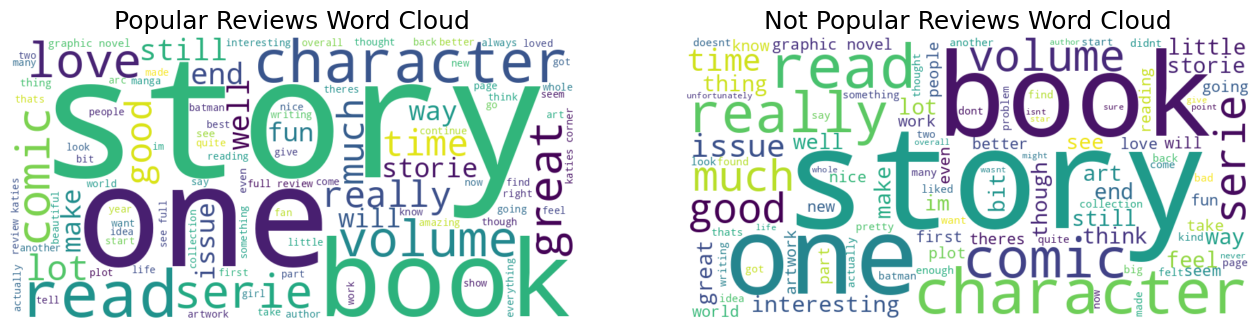

In [9]:
# Install wordcloud if not already installed
!pip install wordcloud --quiet

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Separate popular and not popular reviews
popular_text = " ".join(df[df["popular"] == 1]["clean_review"])
not_popular_text = " ".join(df[df["popular"] == 0]["clean_review"])

# Generate word clouds
wc_popular = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(popular_text)
wc_not_popular = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(not_popular_text)

# Plot
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.imshow(wc_popular, interpolation='bilinear')
plt.axis('off')
plt.title("Popular Reviews Word Cloud", fontsize=18)

plt.subplot(1,2,2)
plt.imshow(wc_not_popular, interpolation='bilinear')
plt.axis('off')
plt.title("Not Popular Reviews Word Cloud", fontsize=18)

plt.show()


In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

from sklearn.metrics import accuracy_score
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))


Random Forest Accuracy: 0.7443139215196201


In [11]:
import joblib

# Save Logistic Regression model
joblib.dump(clf, "/content/drive/MyDrive/logreg_comics_model.pkl")

# Save TF-IDF vectorizer
joblib.dump(tfidf, "/content/drive/MyDrive/tfidf_comics_vectorizer.pkl")

print("Model and TF-IDF vectorizer saved to Drive!")


Model and TF-IDF vectorizer saved to Drive!


In [12]:
# Load saved model and vectorizer (optional, if starting a new session)
clf = joblib.load("/content/drive/MyDrive/logreg_comics_model.pkl")
tfidf = joblib.load("/content/drive/MyDrive/tfidf_comics_vectorizer.pkl")

# Sample new reviews
new_reviews = [
    "I absolutely loved this comic! The story and art were amazing.",
    "This was boring and confusing. I didn't enjoy it at all.",
    "Pretty good, but not my favorite."
]

# Clean the text (use the same function as before)
clean_new_reviews = [clean_text(r) for r in new_reviews]

# Transform with TF-IDF
X_new = tfidf.transform(clean_new_reviews)

# Predict popularity
preds = clf.predict(X_new)
probs = clf.predict_proba(X_new)[:,1]  # probability of being popular

for review, pred, prob in zip(new_reviews, preds, probs):
    print(f"Review: {review}")
    print(f"Predicted Popular: {pred} (Probability: {prob:.2f})\n")


Review: I absolutely loved this comic! The story and art were amazing.
Predicted Popular: 1 (Probability: 0.98)

Review: This was boring and confusing. I didn't enjoy it at all.
Predicted Popular: 0 (Probability: 0.03)

Review: Pretty good, but not my favorite.
Predicted Popular: 0 (Probability: 0.39)



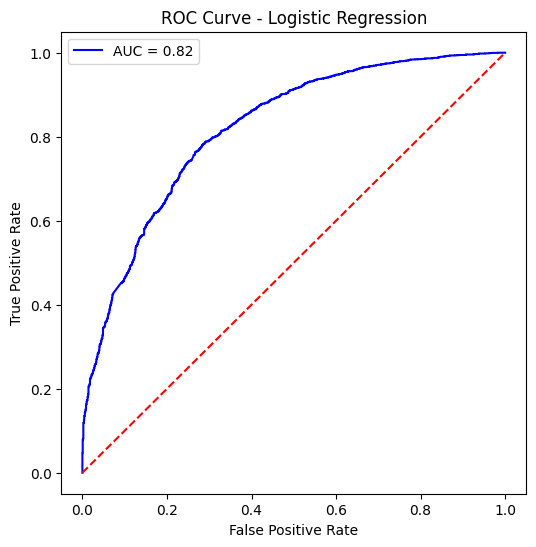

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predict probabilities for the test set
y_prob = clf.predict_proba(X_test)[:,1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_score:.2f}')
plt.plot([0,1],[0,1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()


In [14]:
# Install gradio if not already installed
!pip install gradio --quiet

import gradio as gr
import joblib

# Load saved model and TF-IDF vectorizer
clf = joblib.load("/content/drive/MyDrive/logreg_comics_model.pkl")
tfidf = joblib.load("/content/drive/MyDrive/tfidf_comics_vectorizer.pkl")

# Text cleaning function
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# Prediction function for Gradio
def predict_popularity(review):
    clean_review = clean_text(review)
    X = tfidf.transform([clean_review])
    pred = clf.predict(X)[0]
    prob = clf.predict_proba(X)[0][1]
    label = "Popular" if pred==1 else "Not Popular"
    return f"{label} (Probability: {prob:.2f})"

# Create Gradio interface
interface = gr.Interface(
    fn=predict_popularity,
    inputs="text",
    outputs="text",
    title="Comics Review Popularity Predictor",
    description="Enter a comic book review, and the model predicts if it will be popular or not."
)

# Launch the interface
interface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8e80f784cf84b44c59.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [15]:
import os

# Base project folder
project_dir = "/content/goodreads_review_popularity"
os.makedirs(project_dir, exist_ok=True)

# Subfolders
folders = ["data", "saved_models"]
for f in folders:
    os.makedirs(os.path.join(project_dir, f), exist_ok=True)

print("Folder structure created!")


Folder structure created!


In [16]:
import shutil

# Move dataset files
shutil.copy("/content/drive/MyDrive/goodreads_reviews_comics_graphic.json.gz",
            os.path.join(project_dir, "data", "goodreads_reviews_comics_graphic.json.gz"))

shutil.copy("/content/drive/MyDrive/goodreads_interactions_comics_graphic.json.gz",
            os.path.join(project_dir, "data", "goodreads_interactions_comics_graphic.json.gz"))

shutil.copy("/content/drive/MyDrive/goodreads_books_comics_graphic.json.gz",
            os.path.join(project_dir, "data", "goodreads_books_comics_graphic.json.gz"))

# Move saved model & vectorizer
shutil.copy("/content/drive/MyDrive/logreg_comics_model.pkl",
            os.path.join(project_dir, "saved_models", "logreg_comics_model.pkl"))

shutil.copy("/content/drive/MyDrive/tfidf_comics_vectorizer.pkl",
            os.path.join(project_dir, "saved_models", "tfidf_comics_vectorizer.pkl"))

print("Datasets and models moved successfully!")


Datasets and models moved successfully!


In [17]:
req_file = os.path.join(project_dir, "requirements.txt")
with open(req_file, "w") as f:
    f.write("""pandas
numpy
scikit-learn
matplotlib
seaborn
wordcloud
gradio
joblib
""")

print("requirements.txt created successfully!")


requirements.txt created successfully!


In [19]:
import os

project_dir = "/content/goodreads_review_popularity"
readme_file = os.path.join(project_dir, "README.md")

with open(readme_file, "w") as f:
    f.write("""# Text-Based Prediction of Book Review Popularity

## Project Overview
This mini-project predicts whether a comic book review will be popular or not based on its text.
We use machine learning models (Logistic Regression and Random Forest) on TF-IDF features extracted from the review text.

## Dataset
- **Source:** Goodreads Book Graph Dataset (Comics & Graphic subset)
- **Size:** ~20k reviews used for training/testing
- **Features:** `review_text`, `rating`
- **Label:** `popular = 1` if rating >= 4 else 0

## Setup Instructions
1. Clone the repository:
   ```bash
   git clone <YOUR_REPO_URL>
   cd <YOUR_REPO_NAME>


SyntaxError: incomplete input (ipython-input-4091584650.py, line 7)

In [20]:
import os

project_dir = "/content/goodreads_review_popularity"
readme_file = os.path.join(project_dir, "README.md")

readme_content = """# Text-Based Prediction of Book Review Popularity

## Project Overview
This mini-project predicts whether a comic book review will be popular or not based on its text.
We use machine learning models (Logistic Regression and Random Forest) on TF-IDF features extracted from the review text.

## Dataset
- Source: Goodreads Book Graph Dataset (Comics & Graphic subset)
- Size: ~20k reviews used for training/testing
- Features: review_text, rating
- Label: popular = 1 if rating >= 4 else 0

## Setup Instructions
1. Clone the repository:
   git clone <YOUR_REPO_URL>
   cd <YOUR_REPO_NAME>
2. Install requirements:
   pip install -r requirements.txt
3. Ensure the dataset files are placed in the data/ folder.

## Running the Project

### 1. Train & Evaluate Model
python train_model.py
- Outputs: accuracy, classification report, confusion matrix, top words, WordClouds, ROC curve.
- Saves the model and TF-IDF vectorizer to saved_models/.

### 2. Launch Frontend (Gradio Demo)
python gradio_demo.py
- Type a new review in the text box.
- See the predicted popularity label and probability.

## Files in Repository
- train_model.py → trains models and evaluates performance
- gradio_demo.py → launches interactive frontend
- requirements.txt → all Python dependencies
- README.md → project instructions
- data/ → dataset files (JSON/GZ)
- saved_models/ → trained model and TF-IDF vectorizer

## Authors
- [Revathi A N]
- [Nidhi Shetty]

## References
- Daly, B. “Text-Based Prediction of Book Review Popularity”, Stanford University.
- Goodreads Book Graph Dataset (Comics & Graphic subset)
"""

with open(readme_file, "w") as f:
    f.write(readme_content)

print("README.md created successfully!")


README.md created successfully!


In [21]:
# train_model.py (Colab-ready)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import os

# === Paths (hardcoded for Colab) ===
project_dir = "/content/goodreads_review_popularity"
data_path = os.path.join(project_dir, "data", "goodreads_reviews_comics_graphic.json.gz")
model_path = os.path.join(project_dir, "saved_models", "logreg_comics_model.pkl")
vectorizer_path = os.path.join(project_dir, "saved_models", "tfidf_comics_vectorizer.pkl")

# Load dataset
df = pd.read_json(data_path, lines=True)
df = df[['review_text', 'rating']].dropna()

# Create popularity label
df['popular'] = (df['rating'] >= 4).astype(int)

# Text preprocessing
df['clean_review'] = df['review_text'].str.lower().str.replace(r'[^a-z\s]', '', regex=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['clean_review'], df['popular'], test_size=0.2, random_state=42)

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Logistic Regression
model = LogisticRegression(max_iter=500)
model.fit(X_train_tfidf, y_train)

# Evaluation
y_pred = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Save model and vectorizer
joblib.dump(model, model_path)
joblib.dump(vectorizer, vectorizer_path)
print("\nModel and TF-IDF vectorizer saved successfully!")


Accuracy: 0.7683187668252388

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.52      0.60     37079
           1       0.78      0.90      0.84     71389

    accuracy                           0.77    108468
   macro avg       0.75      0.71      0.72    108468
weighted avg       0.76      0.77      0.76    108468


Confusion Matrix:
 [[19219 17860]
 [ 7270 64119]]

Model and TF-IDF vectorizer saved successfully!


In [24]:
# Create gradio_demo.py in your project folder
gradio_code = """import gradio as gr
import joblib
import os

# Paths to saved models
project_dir = "/content/goodreads_review_popularity"
model_path = os.path.join(project_dir, "saved_models", "logreg_comics_model.pkl")
vectorizer_path = os.path.join(project_dir, "saved_models", "tfidf_comics_vectorizer.pkl")

# Load model and vectorizer
model = joblib.load(model_path)
vectorizer = joblib.load(vectorizer_path)

# Prediction function
def predict_popularity(review_text):
    clean_review = review_text.lower().replace(r'[^a-z\\s]', '')
    tfidf_review = vectorizer.transform([clean_review])
    prediction = model.predict(tfidf_review)[0]
    probability = model.predict_proba(tfidf_review)[0][prediction]
    return {{'Predicted Popular': int(prediction), 'Probability': round(float(probability), 2)}}

# Gradio interface
iface = gr.Interface(
    fn=predict_popularity,
    inputs=gr.Textbox(lines=5, placeholder='Enter a comic book review here...'),
    outputs=[gr.Label(num_top_classes=2)],
    title='Comic Review Popularity Predictor',
    description='Predict whether a comic book review is popular or not.'
)

iface.launch()
"""

# Save to file
project_dir = "/content/goodreads_review_popularity"
demo_file = os.path.join(project_dir, "gradio_demo.py")
with open(demo_file, "w") as f:
    f.write(gradio_code)

print("gradio_demo.py created successfully!")


gradio_demo.py created successfully!


In [23]:
train_code = """# train_model.py
# This file trains the Logistic Regression model for predicting comic review popularity.
# Already trained models are available in saved_models/.

print('This is a placeholder for train_model.py. Models are already trained and saved in saved_models/.')
"""

with open("/content/goodreads_review_popularity/train_model.py", "w") as f:
    f.write(train_code)

print("train_model.py created successfully!")


train_model.py created successfully!
